# Forecasting Sunspots using Tensorflow

### Dataset

Sunspot dataset was downloaded from Kaggle's website.
https://www.kaggle.com/robervalt/sunspots?select=Sunspots.csv


### Context

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

Source: https://en.wikipedia.org/wiki/Sunspot

### Content :

Monthly Mean Total Sunspot Number, from 1749/01/01 to 2017/08/31

In [3]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.1.0


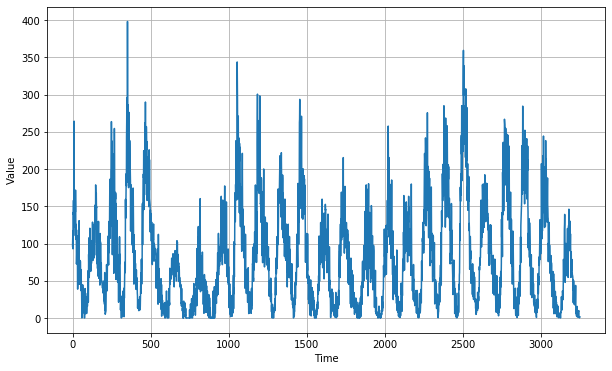

In [9]:
# read the dataset
import csv
time_step = []
sunspots = []

with open('data/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # skip header at first row
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [20]:
# split data into training and test sets
# we have a total of 3252 points. We'll split it 80-20
split_time = round(0.8 * len(time))
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

print(x_train.shape)
print(x_valid.shape)

(2602,)
(650,)


In [22]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # extend the dimension of our series by 1, since RNN require a 3-dim input
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    # divides it into a fixed windowed data for us to easly feed into our RNN
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # shuffle the windowed data to avoid any sequence bias
    ds = ds.shuffle(shuffle_buffer)
    # split data into x and y
    # x being the whole series except the last value
    # y being the last value
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    # group them into batches 
    return ds.batch(batch_size).prefetch(1)

In [23]:
'''
Here we want to find a good value for learning rate.
So we will create a demo model and create a LearningRateScheduler 
that gradually changes the learning rate with epoch number.
We will then plot the learning rate vs. loss to find a 
good value for learning rate.
'''
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2602,)
Epoch 1/100
10/10 [==============================] - 11s 1s/step - loss: 77.7928 - mae: 78.2404
Epoch 2/100
10/10 [==============================] - 4s 415ms/step - loss: 76.4407 - mae: 76.9353
Epoch 3/100
10/10 [==============================] - 4s 378ms/step - loss: 74.4251 - mae: 74.8589
Epoch 4/100
10/10 [==============================] - 4s 402ms/step - loss: 71.8361 - mae: 72.2930
Epoch 5/100
10/10 [==============================] - 5s 480ms/step - loss: 68.9190 - mae: 69.3919
Epoch 6/100
10/10 [==============================] - 5s 488ms/step - loss: 65.8018 - mae: 66.2678
Epoch 7/100
10/10 [==============================] - 4s 398ms/step - loss: 62.5432 - mae: 63.0470
Epoch 8/100
10/10 [==============================] - 4s 393ms/step - loss: 59.3857 - mae: 59.8633
Epoch 9/100
10/10 [==============================] - 4s 378ms/step - loss: 56.3187 - mae: 56.8136
Epoch 10/100
10/10

10/10 [==============================] - 4s 373ms/step - loss: 21.6659 - mae: 22.1749
Epoch 83/100
10/10 [==============================] - 4s 399ms/step - loss: 27.9447 - mae: 28.4578
Epoch 84/100
10/10 [==============================] - 4s 371ms/step - loss: 30.2142 - mae: 30.6921
Epoch 85/100
10/10 [==============================] - 4s 369ms/step - loss: 29.9495 - mae: 30.3650
Epoch 86/100
10/10 [==============================] - 4s 375ms/step - loss: 42.5488 - mae: 43.0849
Epoch 87/100
10/10 [==============================] - 4s 396ms/step - loss: 44.3940 - mae: 44.8732
Epoch 88/100
10/10 [==============================] - 4s 374ms/step - loss: 34.0026 - mae: 34.3810
Epoch 89/100
10/10 [==============================] - 4s 369ms/step - loss: 47.5749 - mae: 48.0728
Epoch 90/100
10/10 [==============================] - 4s 373ms/step - loss: 55.8526 - mae: 56.3650
Epoch 91/100
10/10 [==============================] - 4s 395ms/step - loss: 52.3869 - mae: 52.8815
Epoch 92/100
10/10 [===

[1e-08, 0.0001, 0, 60]

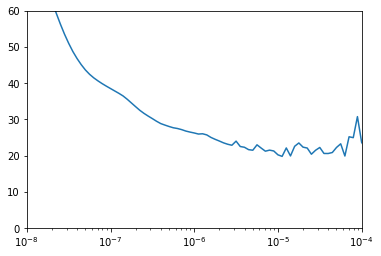

In [24]:
# plot the learning rate vs. loss on log scale
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Loss decreases as we increase learning rate to about 10^-5 before it becomes unstable and increases again. So 1e-5 seems to be a good value for learning rate.

Let's start the training again, this time with a set value for learning rate, and for 500 epochs. As before, we have used a deep neural netwrok with the following architecture:
 
* One 1-dimensional convolutional layer to process the windowed data. This layer has 60 filters each which a kernal size of 5. We have used a 'causal' padding, since it's more appropriate for time series data.
* Two LSTM layers each with 60 units.
* Three Dense layers, with 60, 30 and 1 unit, respectively. 
* After the the last Dense layer we have added a Lambda layer to scale up the values by 400 to improve learning.

verbose=0 is used here we are training for a lot of epochs.

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, verbose=0)

In [28]:
# Helper function to forecast values, given model, series and window size
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [29]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [30]:
# Helper function to plot our series
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

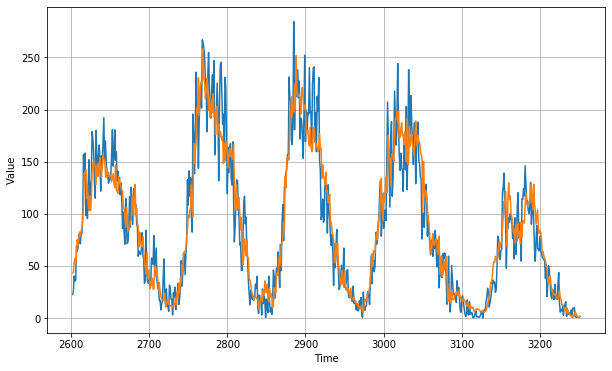

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [32]:
# measure the MAE on validation data
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17.408659

<Figure size 432x288 with 0 Axes>

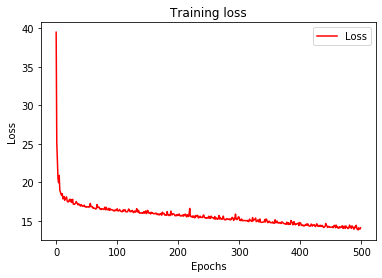

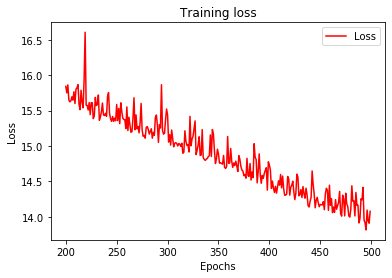

<Figure size 432x288 with 0 Axes>

In [33]:
# look at training loss more closely 
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

# Plot training and validation loss per epoch
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

We trained the model for 500 epochs (which took a a while on a single dual core processor). Taking a closer look at the loss, it looks like the loss was still decreasing, so more training would further  benefit the model accuracy.

In [34]:
# forecast the sunspots
print(rnn_forecast)

[ 43.210403    43.959576    52.519123    56.917805    52.251686
  60.751575    75.1169      69.88999     74.90127     82.58974
  78.54648     82.65336     87.04035     94.70305    109.94074
 138.94289    140.00443    142.30351    114.64665    127.61659
 107.03831    102.96459    116.9637     103.39496    115.23581
 139.66794    147.27966    150.37434    148.31903    144.96748
 128.13292    143.63043    147.93437    136.16402    139.28375
 153.84154    145.2559     135.1645     143.75949    155.62054
 153.25835    151.31505    139.16235    134.8777     143.3867
 137.38895    139.67984    135.15677    136.59702    137.1385
 130.68234    134.59056    138.54315    128.52258    125.07737
 146.70787    123.028114   121.89515    119.4226     135.84897
 131.61029    127.98136    125.64833    122.261024   121.97196
 106.1136     104.68793     97.51792     86.713394   105.93095
  96.103836    84.252495    83.83073     87.04265     92.94048
  93.570885   115.79749    116.85302     98.335075   114